# Keras Intro: Time Series Forecasting

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Time series forecasting

In [2]:
df = pd.read_csv('../data/ZonalDemands_2003-2016.csv',
                 engine='python')
df.head()

,Date,Hour,Total Ontario,Northwest,Northeast,Ottawa,East,Toronto,Essa,Bruce,Southwest,Niagara,West,Tot Zones,diff
0,01-May-03,1,13702,809,1284,965,765,4422,622,41,2729,617,1611,13865,163
1,01-May-03,2,13578,825,1283,923,752,4340,602,43,2731,615,1564,13678,100
2,01-May-03,3,13411,834,1277,910,751,4281,591,45,2696,596,1553,13534,123
3,01-May-03,4,13501,835,1277,922,758,4281,599,41,2724,609,1544,13590,89
4,01-May-03,5,14010,847,1268,993,804,4469,643,51,2842,579,1592,14088,78


In [3]:
df['Datetime'] = pd.to_datetime(df['Date']) + df['Hour'].apply(lambda h: pd.Timedelta("%d hours" % h))

In [4]:
df = df.set_index('Datetime')

In [5]:
from pandas.tseries.offsets import MonthEnd

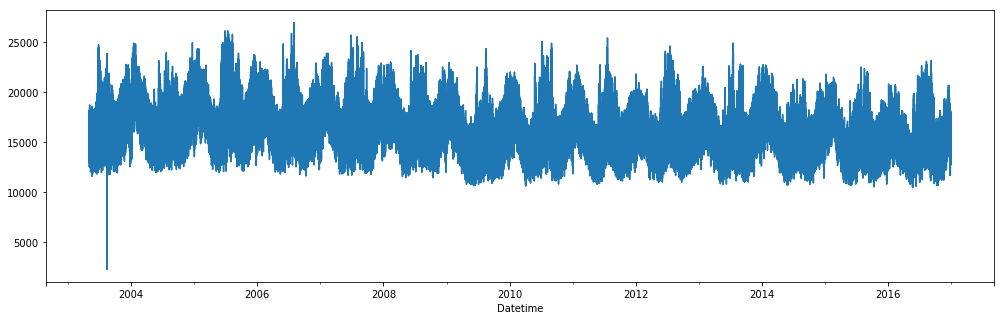

In [6]:
df['Total Ontario'].plot(figsize=(17,5))

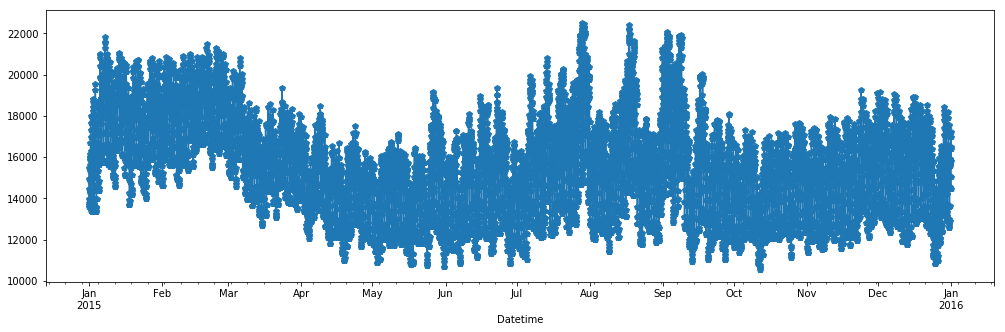

In [7]:
df['2015-01-01':'2015-12-31']['Total Ontario'].plot(style='p-', figsize=(17,5))

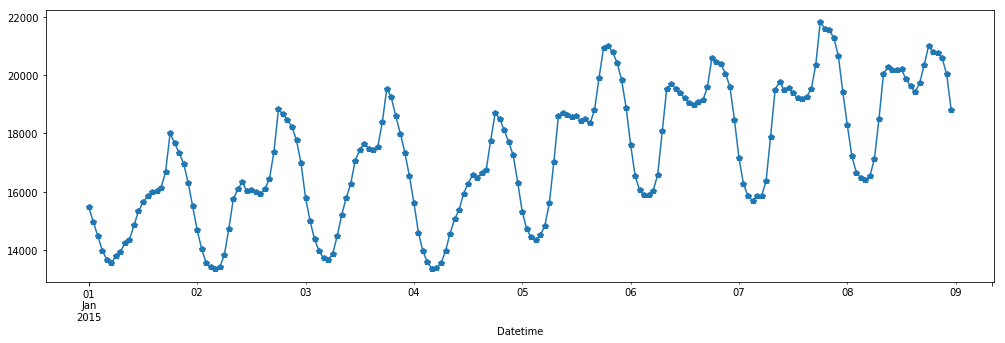

In [40]:
df['2015-01-01':'2015-01-08']['Total Ontario'].plot(style='p-', figsize=(17,5))

In [8]:
split_date = pd.Timestamp('01-01-2014')

In [9]:
train = df.loc[:split_date, ['Total Ontario']]
test = df.loc[split_date:, ['Total Ontario']]

In [10]:
train.shape, test.shape

((93552, 1), (26305, 1))

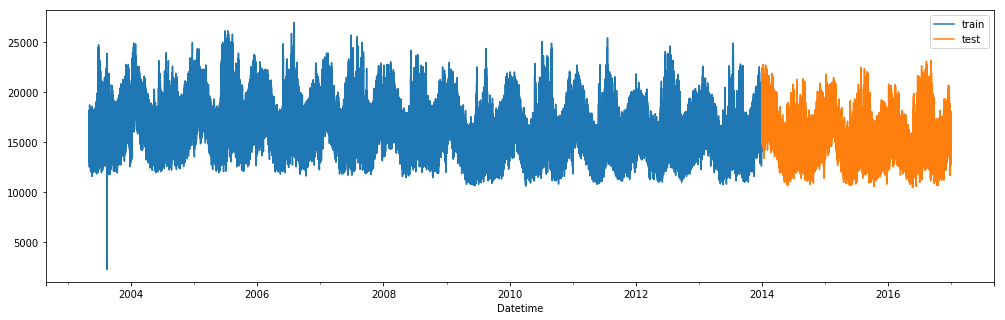

In [11]:
ax = train.plot(figsize=(17,5))
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [12]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [13]:
train_sc[:4]

array([[0.4621791 ],
       [0.45716596],
       [0.45041439],
       [0.45405296]])

shifting the data by 1 index to apply the simplest prediction strategy, current val as function of previous value

In [14]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((93551, 1), (93551, 1), (26304, 1), (26304, 1))

### Fully connected predictor

In [16]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [17]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                24        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________


In [18]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

In [19]:
model.fit(X_train, y_train, epochs=200,
          batch_size=500, verbose=1,
          callbacks=[early_stop])

Epoch 1/200
93551/93551 [==============================] - 1s 15us/step - loss: 0.1256
Epoch 2/200
93551/93551 [==============================] - 1s 6us/step - loss: 0.0050
Epoch 3/200
93551/93551 [==============================] - 1s 7us/step - loss: 0.0044
Epoch 4/200
93551/93551 [==============================] - 1s 6us/step - loss: 0.0040
Epoch 5/200
93551/93551 [==============================] - 1s 6us/step - loss: 0.0034
Epoch 6/200
93551/93551 [==============================] - 1s 7us/step - loss: 0.0027
Epoch 7/200
93551/93551 [==============================] - 1s 7us/step - loss: 0.0023
Epoch 8/200
93551/93551 [==============================] - 1s 7us/step - loss: 0.0021
Epoch 9/200
93551/93551 [==============================] - 1s 7us/step - loss: 0.0018
Epoch 10/200
93551/93551 [==============================] - 1s 7us/step - loss: 0.0016
Epoch 11/200
93551/93551 [==============================] - 1s 7us/step - loss: 0.0014
Epoch 12/200
93551/93551 [=========================

In [20]:
y_pred = model.predict(X_test)

(1200, 1300)

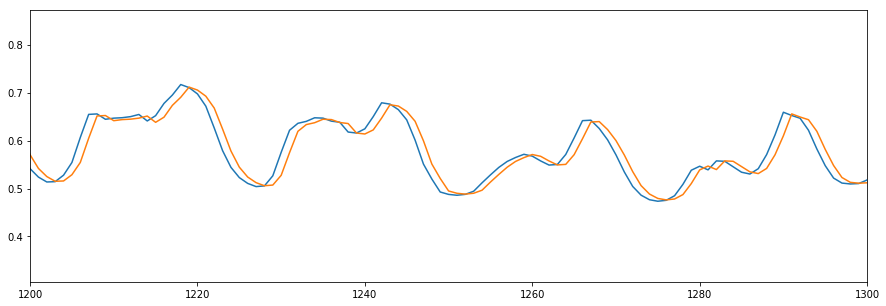

In [21]:
plt.figure(figsize=(15,5))
plt.plot(y_test)
plt.plot(y_pred)
plt.xlim(1200,1300)

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
mean_squared_error(y_test, y_pred)

0.0006094966872657046

## Lagged features

In [24]:
train_sc.shape

(93552, 1)

In [25]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
train_sc_df.head()

,Scaled
Datetime,
2003-05-01 01:00:00,0.462179
2003-05-01 02:00:00,0.457166
2003-05-01 03:00:00,0.450414
2003-05-01 04:00:00,0.454053
2003-05-01 05:00:00,0.474631


In [26]:
window_size = 24

In [27]:
for s in range(1, window_size + 1):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

In [28]:
train_sc_df.head(window_size)

,Scaled,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,...,shift_15,shift_16,shift_17,shift_18,shift_19,shift_20,shift_21,shift_22,shift_23,shift_24
Datetime,,,,,,,,,,,,,,,,,,,,,
2003-05-01 01:00:00,0.462179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-05-01 02:00:00,0.457166,0.462179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-05-01 03:00:00,0.450414,0.457166,0.462179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-05-01 04:00:00,0.454053,0.450414,0.457166,0.462179,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-05-01 05:00:00,0.474631,0.454053,0.450414,0.457166,0.462179,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-05-01 06:00:00,0.519224,0.474631,0.454053,0.450414,0.457166,0.462179,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-05-01 07:00:00,0.585890,0.519224,0.474631,0.454053,0.450414,0.457166,0.462179,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-05-01 08:00:00,0.626562,0.585890,0.519224,0.474631,0.454053,0.450414,0.457166,0.462179,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-05-01 09:00:00,0.637437,0.626562,0.585890,0.519224,0.474631,0.454053,0.450414,0.457166,0.462179,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
X_train = train_sc_df.dropna().drop('Scaled', axis=1).values
y_train = train_sc_df.dropna()[['Scaled']].values

X_test = test_sc_df.dropna().drop('Scaled', axis=1).values
y_test = test_sc_df.dropna()[['Scaled']].values

In [30]:
X_train.shape

(93528, 24)

### Fully Connected on Windows

In [31]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=window_size, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 313
Trainable params: 313
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.fit(X_train, y_train, epochs=200,
          batch_size=500, verbose=1, callbacks=[early_stop])

Epoch 1/200
93528/93528 [==============================] - 1s 9us/step - loss: 0.0040
Epoch 2/200
93528/93528 [==============================] - 1s 7us/step - loss: 0.0010
Epoch 3/200
93528/93528 [==============================] - 1s 8us/step - loss: 8.1248e-04
Epoch 4/200
93528/93528 [==============================] - 1s 8us/step - loss: 6.8483e-04
Epoch 5/200
93528/93528 [==============================] - 1s 8us/step - loss: 6.0214e-04
Epoch 6/200
93528/93528 [==============================] - 1s 8us/step - loss: 5.3490e-04
Epoch 7/200
93528/93528 [==============================] - 1s 8us/step - loss: 4.8258e-04
Epoch 8/200
93528/93528 [==============================] - 1s 8us/step - loss: 4.4398e-04
Epoch 9/200
93528/93528 [==============================] - 1s 8us/step - loss: 4.0319e-04
Epoch 10/200
93528/93528 [==============================] - 1s 8us/step - loss: 3.7312e-04
Epoch 11/200
93528/93528 [==============================] - 1s 8us/step - loss: 3.5239e-04
Epoch 12/200
935

In [33]:
y_pred_fc_window = model.predict(X_test)

(1200, 1300)

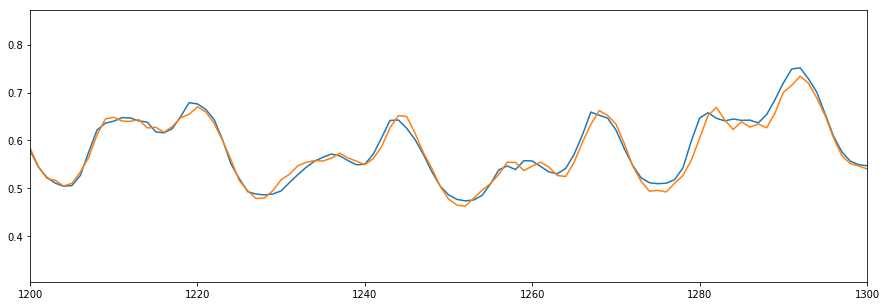

In [34]:
plt.figure(figsize=(15,5))
plt.plot(y_test)
plt.plot(y_pred_fc_window)
plt.xlim(1200,1300)

this modeol, while it performs better than the previous, does demonstrate sensitivities to anomalies/discontinuities that take a few periods to resolve

(22800, 22900)

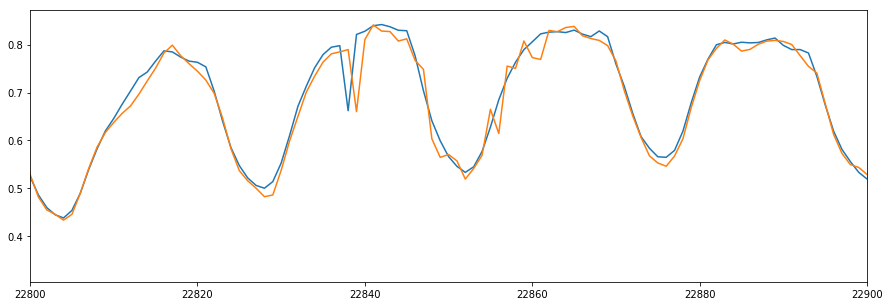

In [35]:
plt.figure(figsize=(15,5))
plt.plot(y_test)
plt.plot(y_pred_fc_window)
plt.xlim(22800,22900)

## Exercise

Reshape the input to `(num_samples, window_size, 1)`. This means we consider each input window as a sequence of `window_size` values that we will pass in sequence to the LSTM. In principle this looks like a more accurate description of our situation. But does it yield better predictions? Let's check it.

- Reshape `X_train` and `X_test` so that they represent a set of univariate sequences
- train the best recurrent model you can, you'll have to adapt the `input_shape`
- check the performance of this new model, is it better at predicting the test data?
- plot your results
- try using GRU instead of LSTM

In [51]:
from keras.layers import LSTM, CuDNNLSTM
from keras.layers import Embedding

In [52]:
window_size=24

X_train_t = X_train.reshape(X_train.shape[0],window_size,1)
X_test_t = X_test.reshape(X_test.shape[0],window_size,1)
print(X_train.shape)
print(X_train_t.shape)

(93528, 24)
(93528, 24, 1)


In [ ]:
K.clear_session()
model = Sequential()
model.add(CuDNNLSTM(12, input_shape=(window_size,1)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train_t, y_train, epochs=100, batch_size=500, callbacks=[early_stop])

In [59]:
y_pred_lstm_window = model.predict(X_test_t)

(1200, 1300)

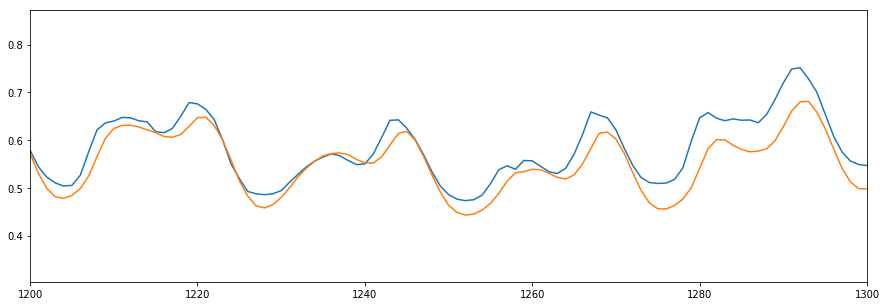

In [60]:
plt.figure(figsize=(15,5))
plt.plot(y_test)
plt.plot(y_pred_lstm_window)
plt.xlim(1200,1300)

(22800, 22900)

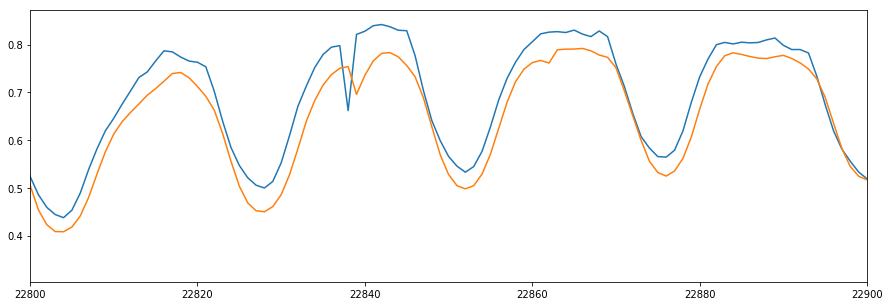

In [61]:
plt.figure(figsize=(15,5))
plt.plot(y_test)
plt.plot(y_pred_lstm_window)
plt.xlim(22800,22900)